# TimesNet Tutorial
**Set-up instructions:** this notebook give a tutorial on the learning task supported by `TimesNet`.

`TimesNet` can support basically 5 tasks, which are respectively long-term forecast, short-term forecast, imputation, anomaly detection, classification.

### 1. Install Python 3.8. For convenience, execute the following command.

In [ ]:
pip install -r requirements.txt

### 2. Package Import

In [ ]:
import torch    
import torch.nn as nn
import torch.nn.functional as F
import torch.fft
from layers.Embed import DataEmbedding
from layers.Conv_Blocks import Inception_Block_V1   
            #convolution block used for convoluting the 2D time data, changeable

### 3. TimesBlock Construction
 The core idea of `TimesNet` lies in the construction of `TimesBlock`, which generally gets the base frequencies by implementing FFT on the data, and then reshapes the times series to 2D variation respectively from the main base frequencies, followed by a 2D convolution whose outputs are reshaped back and added with weight to form the final output.

 In the following section, we will have a detailed view on `TimesBlock`.

 TimesBlock has 2 members. 

In [ ]:
class TimesBlock(nn.Module):
    def __init__(self, configs):
        ...
    
    def forward(self, x):
        ...

First, let's focus on ```__init__(self, configs):```

In [ ]:
def __init__(self, configs):    ##configs is the configuration defined for TimesBlock
    super(TimesBlock, self).__init__() 
    self.seq_len = configs.seq_len   ##sequence length 
    self.pred_len = configs.pred_len ##prediction length
    self.k = configs.top_k    ##k denotes how many top frequencies are 
                                                            #taken into consideration
    # parameter-efficient design
    self.conv = nn.Sequential(
        Inception_Block_V1(configs.d_model, configs.d_ff,
                           num_kernels=configs.num_kernels),
        nn.GELU(),
        Inception_Block_V1(configs.d_ff, configs.d_model,
                           num_kernels=configs.num_kernels)
    )

Then, have a look at ```forward(self, x)```

In [ ]:
def forward(self, x):
        B, T, N = x.size()
            #B: batch size  T: length of time series  N:number of features
        period_list, period_weight = FFT_for_Period(x, self.k)
            #FFT_for_Period() will be shown later. Here, period_list([top_k]) denotes 
            #the top_k-significant period and period_weight([B, top_k]) denotes its weight(amplitude)

        res = []
        for i in range(self.k):
            period = period_list[i]

            # padding : to form a 2D map, we need total length of the sequence, plus the part 
            # to be predicted, to be divisible by the period, so padding is needed
            if (self.seq_len + self.pred_len) % period != 0:
                length = (
                                 ((self.seq_len + self.pred_len) // period) + 1) * period
                padding = torch.zeros([x.shape[0], (length - (self.seq_len + self.pred_len)), x.shape[2]]).to(x.device)
                out = torch.cat([x, padding], dim=1)
            else:
                length = (self.seq_len + self.pred_len)
                out = x

            # reshape: we need each channel of a single piece of data to be a 2D variable,
            # Also, in order to implement the 2D conv later on, we need to adjust the 2 dimensions 
            # to be convolutioned to the last 2 dimensions, by calling the permute() func.
            # Whereafter, to make the tensor contiguous in memory, call contiguous()
            out = out.reshape(B, length // period, period,
                              N).permute(0, 3, 1, 2).contiguous()
            
            #2D convolution to grap the intra- and inter- period information
            out = self.conv(out)

            # reshape back, similar to reshape
            out = out.permute(0, 2, 3, 1).reshape(B, -1, N)
            
            #truncating down the padded part of the output and put it to result
            res.append(out[:, :(self.seq_len + self.pred_len), :])
        res = torch.stack(res, dim=-1) #res: 4D [B, length , N, top_k]

        # adaptive aggregation
        #First, use softmax to get the normalized weight from amplitudes --> 2D [B,top_k]
        period_weight = F.softmax(period_weight, dim=1) 

        #after two unsqueeze(1),shape -> [B,1,1,top_k],so repeat the weight to fit the shape of res
        period_weight = period_weight.unsqueeze(
            1).unsqueeze(1).repeat(1, T, N, 1)
        
        #add by weight the top_k periods' result, getting the result of this TimesBlock
        res = torch.sum(res * period_weight, -1)

        # residual connection
        res = res + x
        return res

The ```FFT_for_Period``` above is given by:

In [ ]:
def FFT_for_Period(x, k=2):
    # xf shape [B, T, C], denoting the amplitude of frequency(T) given the datapiece at B,N
    xf = torch.fft.rfft(x, dim=1) 

    # find period by amplitudes: here we assume that the periodic features are basically constant
    # in different batch and channel, so we mean out these two dimensions, getting a list frequency_list with shape[T] 
    # each element at pos t of frequency_list denotes the overall amplitude at frequency (t)
    frequency_list = abs(xf).mean(0).mean(-1) 
    frequency_list[0] = 0

    #by torch.topk(),we can get the biggest k elements of frequency_list, and its positions(i.e. the k-main frequencies in top_list)
    _, top_list = torch.topk(frequency_list, k)

    #Returns a new Tensor 'top_list', detached from the current graph.
    #The result will never require gradient.Convert to a numpy instance
    top_list = top_list.detach().cpu().numpy()
     
    #period:a list of shape [top_k], recording the periods of mean frequencies respectively
    period = x.shape[1] // top_list

    #Here,the 2nd item returned has a shape of [B, top_k],representing the biggest top_k amplitudes 
    # for each piece of data, with N features being averaged.
    return period, abs(xf).mean(-1)[:, top_list] 

To make it clearer, please see the figures below.

![FFT demonstrator](./fft.png)

![2D Conv demonstrator](./conv.png)

For more details, please read the our paper 
(link: https://openreview.net/pdf?id=ju_Uqw384Oq)

### 4. TimesNet

So far we've got `TimesBlock`, which is excel at retrieving  intra- and inter- period temporal information. We become capable of building a `TimesNet`.  `TimesNet` is proficient in multitasks including short- and long-term forecasting, imputation, classification, and anomaly detection.

In this section, we'll have a detailed overview on how `TimesNet` gains its power in these tasks.

In [ ]:
class Model(nn.Module):
    def __init__(self, configs):
        ...
    
    def forecast(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        ...

    def imputation(self, x_enc, x_mark_enc, x_dec, x_mark_dec, mask):
        ...

    def anomaly_detection(self, x_enc):
        ...
    
    def classification(self, x_enc, x_mark_enc):
        ...

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec, mask=None):
        ...

First of all, let's focus on ```__init__(self, configs):```

In [ ]:
def __init__(self, configs):
    super(Model, self).__init__()
    #params init
    self.configs = configs
    self.task_name = configs.task_name
    self.seq_len = configs.seq_len
    self.label_len = configs.label_len
    self.pred_len = configs.pred_len

    #stack TimesBlock for e_layers times to form the main part of TimesNet, named model
    self.model = nn.ModuleList([TimesBlock(configs)
                                for _ in range(configs.e_layers)])
    
    #embedding & normalization
    # enc_in is the encoder input size, the number of features for a piece of data
    # d_model is the dimension of embedding
    self.enc_embedding = DataEmbedding(configs.enc_in, configs.d_model, configs.embed, configs.freq,
                                       configs.dropout)
    self.layer = configs.e_layers # num of encoder layers
    self.layer_norm = nn.LayerNorm(configs.d_model)

    #define the some layers for different tasks
    if self.task_name == 'long_term_forecast' or self.task_name == 'short_term_forecast':
        self.predict_linear = nn.Linear(
            self.seq_len, self.pred_len + self.seq_len)
        self.projection = nn.Linear(
            configs.d_model, configs.c_out, bias=True)
    if self.task_name == 'imputation' or self.task_name == 'anomaly_detection':
        self.projection = nn.Linear(
            configs.d_model, configs.c_out, bias=True)
    if self.task_name == 'classification':
        self.act = F.gelu
        self.dropout = nn.Dropout(configs.dropout)
        self.projection = nn.Linear(
            configs.d_model * configs.seq_len, configs.num_class)

#### 4.1 Forecast

The basic idea of forecasting is to lengthen the known sequence to (seq_len+pred_len), which is the total length after forecasting. Then by several TimesBlock layers together with layer normalization, some underlying intra- and inter- period information is represented. With these information, we can project it to the output space. Whereafter by denorm ( if Non-stationary Transformer) we get the final output.

In [ ]:
def forecast(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
    # Normalization from Non-stationary Transformer at temporal dimension
    means = x_enc.mean(1, keepdim=True).detach() #[B,T]
    x_enc = x_enc - means
    stdev = torch.sqrt(
        torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5)
    x_enc /= stdev

    # embedding: projecting a number to a C-channel vector
    enc_out = self.enc_embedding(x_enc, x_mark_enc)  # [B,T,C] C is d_model
    enc_out = self.predict_linear(enc_out.permute(0, 2, 1)).permute(
        0, 2, 1)  # align temporal dimension [B,pred_len+seq_len,C]
    
    # TimesNet: pass through TimesBlock for self.layer times each with layer normalization
    for i in range(self.layer):
        enc_out = self.layer_norm(self.model[i](enc_out))

    # project back  #[B,T,d_model]-->[B,T,c_out]
    dec_out = self.projection(enc_out) 

    # De-Normalization from Non-stationary Transformer
    dec_out = dec_out * \
              (stdev[:, 0, :].unsqueeze(1).repeat(
                  1, self.pred_len + self.seq_len, 1)) #lengthen the stdev to fit the dec_out
    dec_out = dec_out + \
              (means[:, 0, :].unsqueeze(1).repeat(
                  1, self.pred_len + self.seq_len, 1)) #lengthen the mean to fit the dec_out
    return dec_out

#### 4.2 Imputation

Imputation is a task aiming at completing some missing value in the time series, so in some degree it's similar to forecast. We can still use the similar step to cope with it.

In [ ]:
def imputation(self, x_enc, x_mark_enc, x_dec, x_mark_dec, mask):
    # Normalization from Non-stationary Transformer
    means = torch.sum(x_enc, dim=1) / torch.sum(mask == 1, dim=1)
    means = means.unsqueeze(1).detach()
    x_enc = x_enc - means
    x_enc = x_enc.masked_fill(mask == 0, 0)
    stdev = torch.sqrt(torch.sum(x_enc * x_enc, dim=1) /
                       torch.sum(mask == 1, dim=1) + 1e-5)
    stdev = stdev.unsqueeze(1).detach()
    x_enc /= stdev

    # embedding
    enc_out = self.enc_embedding(x_enc, x_mark_enc)  # [B,T,C]
    # TimesNet
    for i in range(self.layer):
        enc_out = self.layer_norm(self.model[i](enc_out))
    # project back
    dec_out = self.projection(enc_out)

    # De-Normalization from Non-stationary Transformer
    dec_out = dec_out * \
              (stdev[:, 0, :].unsqueeze(1).repeat(
                  1, self.pred_len + self.seq_len, 1))
    dec_out = dec_out + \
              (means[:, 0, :].unsqueeze(1).repeat(
                  1, self.pred_len + self.seq_len, 1))
    return dec_out

#### 4.3 Anomaly Detection

Similar to Imputation.

In [ ]:
def anomaly_detection(self, x_enc):
    # Normalization from Non-stationary Transformer
    means = x_enc.mean(1, keepdim=True).detach()
    x_enc = x_enc - means
    stdev = torch.sqrt(
        torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5)
    x_enc /= stdev
    # embedding
    enc_out = self.enc_embedding(x_enc, None)  # [B,T,C]
    # TimesNet
    for i in range(self.layer):
        enc_out = self.layer_norm(self.model[i](enc_out))
    # project back
    dec_out = self.projection(enc_out)
    # De-Normalization from Non-stationary Transformer
    dec_out = dec_out * \
              (stdev[:, 0, :].unsqueeze(1).repeat(
                  1, self.pred_len + self.seq_len, 1))
    dec_out = dec_out + \
              (means[:, 0, :].unsqueeze(1).repeat(
                  1, self.pred_len + self.seq_len, 1))
    return dec_out

#### 4.4 Classification

In [ ]:
def classification(self, x_enc, x_mark_enc):
        # embedding
        enc_out = self.enc_embedding(x_enc, None)  # [B,T,C]
        # TimesNet
        for i in range(self.layer):
            enc_out = self.layer_norm(self.model[i](enc_out))

        # Output
        # the output transformer encoder/decoder embeddings don't include non-linearity
        output = self.act(enc_out)
        output = self.dropout(output)

        # zero-out padding embeddings:The primary role of x_mark_enc in the code is to 
        # zero out the embeddings for padding positions in the output tensor through 
        # element-wise multiplication, helping the model to focus on meaningful data 
        # while disregarding padding.
        output = output * x_mark_enc.unsqueeze(-1)
        
        # (batch_size, seq_length * d_model)
        output = output.reshape(output.shape[0], -1)
        output = self.projection(output)  # (batch_size, num_classes)
        return output

In the end, with so many tasks above, we become able to complete `forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec, mask=None):`. 

In [ ]:
def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec, mask=None):
    if self.task_name == 'long_term_forecast' or self.task_name == 'short_term_forecast':
        dec_out = self.forecast(x_enc, x_mark_enc, x_dec, x_mark_dec)
        return dec_out[:, -self.pred_len:, :]  # [B, L, D] return the predicted part of sequence
    if self.task_name == 'imputation':
        dec_out = self.imputation(
            x_enc, x_mark_enc, x_dec, x_mark_dec, mask)
        return dec_out  # [B, L, D] return the whole sequence with missing value estimated
    if self.task_name == 'anomaly_detection':
        dec_out = self.anomaly_detection(x_enc)
        return dec_out  # [B, L, D] return the sequence that should be correct
    if self.task_name == 'classification':
        dec_out = self.classification(x_enc, x_mark_enc)
        return dec_out  # [B, N] return the classification result
    return None

### 5. Training and Settings

By now we've successfully build up `TimesNet`. We are now facing the problem how to train and test this neural network. The action of training, validating as well as testing is implemented at __*exp*__ part, in which codes for different tasks are gathered. These experiments are not only for `TimesNet` training, but also feasible for any other time series representation model. But here, we simply use `TimesNet` to analyse.

`TimesNet` is a state-of-art in multiple tasks, while here we would only introduce its training for long-term forecast task, since the backbone of the training process for other tasks is similar to this one. Again, test and validation code can be easily understood once you've aware how the training process works. So first of all, we are going to focus on the training of `TimesNet` on task long-term forecasting.

We will discuss many aspects, including the training process, training loss etc.

#### 5.1 Training for Long-term Forecast Task

The following codes represents the process of training model for long-term forecasting task. We'll have a detailed look at it. To make it brief, the training part can be briefly divided into several parts, including Data Preparation, Creating Save Path, Initialization, Optimizer and Loss Function Selection, Using Mixed Precision Training, Training Loop, Validation and Early Stopping, Learning Rate Adjustment, Loading the Best Model.

For more details, please see the code below. 'train' process is defined in the experiment  <font color=orange>__class Exp_Long_Term_Forecast__</font>.

In [ ]:
import os

In [ ]:
def train(self, setting):  #setting is the args for this model training
    #get train dataloader
    train_data, train_loader = self._get_data(flag='train')
    vali_data, vali_loader = self._get_data(flag='val')
    test_data, test_loader = self._get_data(flag='test')

    # set path of checkpoint for saving and loading model
    path = os.path.join(self.args.checkpoints, setting)
    if not os.path.exists(path):
        os.makedirs(path)
    time_now = time.time()

    train_steps = len(train_loader)

    # EarlyStopping is typically a custom class or function that monitors the performance 
    # of a model during training, usually by tracking a certain metric (commonly validation 
    # loss or accuracy).It's a common technique used in deep learning to prevent overfitting 
    # during the training
    early_stopping = EarlyStopping(patience=self.args.patience, verbose=True)

    #Optimizer and Loss Function Selection
    model_optim = self._select_optimizer()
    criterion = self._select_criterion()

    # AMP training is a technique that uses lower-precision data types (e.g., float16) 
    # for certain computations to accelerate training and reduce memory usage.
    if self.args.use_amp:  
        scaler = torch.cuda.amp.GradScaler()
    for epoch in range(self.args.train_epochs):
        iter_count = 0
        train_loss = []
        self.model.train()
        epoch_time = time.time()

        #begin training in this epoch
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):
            iter_count += 1
            model_optim.zero_grad()
            batch_x = batch_x.float().to(self.device)  #input features
            batch_y = batch_y.float().to(self.device)  #target features

            # _mark holds information about time-related features. Specifically, it is a 
            # tensor that encodes temporal information and is associated with the 
            # input data batch_x.
            batch_x_mark = batch_x_mark.float().to(self.device)
            batch_y_mark = batch_y_mark.float().to(self.device)
            # decoder input(didn't use in TimesNet case)
            dec_inp = torch.zeros_like(batch_y[:, -self.args.pred_len:, :]).float()
            dec_inp = torch.cat([batch_y[:, :self.args.label_len, :], dec_inp], dim=1).float().to(self.device)
            # encoder - decoder
            if self.args.use_amp: #in the case of TimesNet, use_amp should be False
                with torch.cuda.amp.autocast():
                    # whether to output attention in ecoder,in TimesNet case is no
                    if self.args.output_attention: 
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                    # model the input
                    else:
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

                    # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, 
                    # S:univariate predict univariate, MS:multivariate predict univariate'
                    #if multivariate predict univariate',then output should be the last column of the decoder
                    # output, so f_dim = -1 to only contain the last column, else is all columns
                    f_dim = -1 if self.args.features == 'MS' else 0 
                    outputs = outputs[:, -self.args.pred_len:, f_dim:]
                    batch_y = batch_y[:, -self.args.pred_len:, f_dim:].to(self.device)

                    # calc loss
                    loss = criterion(outputs, batch_y)
                    train_loss.append(loss.item())
            else:  #similar to when use_amp is True
                if self.args.output_attention:
                    outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                else:
                    outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                f_dim = -1 if self.args.features == 'MS' else 0
                outputs = outputs[:, -self.args.pred_len:, f_dim:]
                batch_y = batch_y[:, -self.args.pred_len:, f_dim:].to(self.device)
                loss = criterion(outputs, batch_y)
                train_loss.append(loss.item())

            # When train rounds attain some 100-multiple, print speed, left time, loss. etc feedback
            if (i + 1) % 100 == 0:
                print("\titers: {0}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item()))
                speed = (time.time() - time_now) / iter_count
                left_time = speed * ((self.args.train_epochs - epoch) * train_steps - i)
                print('\tspeed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
                iter_count = 0
                time_now = time.time()

            #BP
            if self.args.use_amp:
                scaler.scale(loss).backward()
                scaler.step(model_optim)
                scaler.update()
            else:
                loss.backward()
                model_optim.step()
        
        #This epoch comes to end, print information
        print("Epoch: {} cost time: {}".format(epoch + 1, time.time() - epoch_time))
        train_loss = np.average(train_loss)

        #run test and validation on current model
        vali_loss = self.vali(vali_data, vali_loader, criterion)
        test_loss = self.vali(test_data, test_loader, criterion)

        #print train, test, vali loss information
        print("Epoch: {0}, Steps: {1} | Train Loss: {2:.7f} Vali Loss: {3:.7f} Test Loss: {4:.7f}".format(
            epoch + 1, train_steps, train_loss, vali_loss, test_loss))
        
        #Decide whether to trigger Early Stopping. if early_stop is true, it means that 
        #this epoch's training is now at a flat slope, so stop further training for this epoch.
        early_stopping(vali_loss, self.model, path)
        if early_stopping.early_stop:
            print("Early stopping")
            break

        #adjust learning keys
        adjust_learning_rate(model_optim, epoch + 1, self.args)
    best_model_path = path + '/' + 'checkpoint.pth'

    # loading the trained model's state dictionary from a saved checkpoint file 
    # located at best_model_path.
    self.model.load_state_dict(torch.load(best_model_path))
    return self.model

If you want to learn more, please see it at exp/exp_long_term_forecasting.py

#### 5.2 Early Stopping Mechanism

<font color=purple>__EarlyStopping__</font> is typically a custom class or function that monitors the performance of a model during training, usually by tracking a certain metric (commonly validation loss or accuracy).It's a common technique used in deep learning to prevent overfitting during the training.

Let's see the code below(original code is in `tools.py`).

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience # how many times will you tolerate for loss not being on decrease
        self.verbose = verbose  # whether to print tip info
        self.counter = 0 # now how many times loss not on decrease
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)

        # meaning: current score is not 'delta' better than best_score, representing that 
        # further training may not bring remarkable improvement in loss. 
        elif score < self.best_score + self.delta:  
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            # 'No Improvement' times become higher than patience --> Stop Further Training
            if self.counter >= self.patience:
                self.early_stop = True

        else: #model's loss is still on decrease, save the now best model and go on training
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
    ### used for saving the current best model
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
        self.val_loss_min = val_loss

#### 5.3 Optimizer and Criterion

The optimizer and criterion are defined in <font color=orange>__class Exp_Long_Term_Forecast__</font> and called in the training process by function `self._select_optimizer()` and `self._select_criterion()`. Here, for long-term forecasting task, we simply adopt Adam optimizer and MSELoss to meature the loss between real data and predicted ones.

In [ ]:
def _select_optimizer(self):
    model_optim = optim.Adam(self.model.parameters(), lr=self.args.learning_rate)
    return model_optim

def _select_criterion(self):
    criterion = nn.MSELoss()
    return criterion

#### 5.4 Automatic Mixed Precision（AMP）

AMP is a technique used in deep learning to improve training speed and reduce memory usage. AMP achieves this by mixing calculations in half-precision (16-bit floating-point) and single-precision (32-bit floating-point).

Let's have a closer look on this snippet:

In [ ]:
#in forward process:
with torch.cuda.amp.autocast():

...

#in BP process:
if self.args.use_amp:
    scaler.scale(loss).backward()
    scaler.step(model_optim)
    scaler.update()


` with torch.cuda.amp.autocast():` :  The purpose of using torch.cuda.amp.autocast() is to take advantage of the speed and memory efficiency benefits of mixed-precision training while maintaining numerical stability. Some deep learning models can benefit significantly from this technique, especially on modern GPUs with hardware support for half-precision arithmetic. It allows you to perform certain calculations more quickly while still ensuring that critical calculations (e.g., gradient updates) are performed with sufficient precision to avoid loss of accuracy.

`scaler.scale(loss).backward()`: If AMP is enabled, it uses a scaler object created with torch.cuda.amp.GradScaler() to automatically scale the loss and perform backward propagation. This is a crucial part of AMP, ensuring numerical stability. Before backpropagation, the loss is scaled to an appropriate range to prevent gradients from diverging too quickly or causing numerical instability.

`scaler.step(model_optim)`: Next, the scaler calls the step method, which applies the scaled gradients to the model's optimizer (model_optim). This is used to update the model's weights to minimize the loss function.

`scaler.update()`: Finally, the scaler calls the update method, which updates the scaling factor to ensure correct scaling of the loss for the next iteration. This step helps dynamically adjust the scaling of gradients to adapt to different training scenarios.

#### 5.5 Learning Rate Adjustment

While the optimizer are responsible for adapting the learning rate with epochs, we would still like to do some adjustment on it manually, as indicated in the function `adjust_learning_rate(model_optim, epoch + 1, self.args)`, whose codes are shown below(original code is in `tools.py`): 

In [ ]:
def adjust_learning_rate(optimizer, epoch, args):

    #first type: learning rate decrease with epoch by exponential
    if args.lradj == 'type1':
        lr_adjust = {epoch: args.learning_rate * (0.5 ** ((epoch - 1) // 1))}

    #second type: learning rate decrease manually
    elif args.lradj == 'type2':
        lr_adjust = {
            2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
            10: 5e-7, 15: 1e-7, 20: 5e-8
        }

    #1st type: update in each epoch
    #2nd type: only update in epochs that are written in Dict lr_adjust
    if epoch in lr_adjust.keys():
        lr = lr_adjust[epoch]
    
        # change the learning rate for different parameter groups within the optimizer
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        print('Updating learning rate to {}'.format(lr))

### 6. Validation and Testing

During training, the model continuously adjusts its weights and parameters to minimize training error. However, this may not reflect the model's performance on unseen data. Validation allows us to periodically assess the model's performance on data that is different from the training data, providing insights into the model's generalization ability.

By comparing performance on the validation set, we can identify whether the model is overfitting. Overfitting occurs when a model performs well on training data but poorly on unseen data. Monitoring performance on the validation set helps detect overfitting early and take measures to prevent it, such as early stopping or adjusting hyperparameters.

Here, we still take long-term forecasting as an example, similar to train process:

In [ ]:
def vali(self, vali_data, vali_loader, criterion):
        total_loss = []

        #evaluation mode
        self.model.eval()
        with torch.no_grad():
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(vali_loader):
                batch_x = batch_x.float().to(self.device)
                batch_y = batch_y.float()

                batch_x_mark = batch_x_mark.float().to(self.device)
                batch_y_mark = batch_y_mark.float().to(self.device)

                # decoder input
                dec_inp = torch.zeros_like(batch_y[:, -self.args.pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :self.args.label_len, :], dec_inp], dim=1).float().to(self.device)
                # encoder - decoder
                if self.args.use_amp:
                    with torch.cuda.amp.autocast():
                        if self.args.output_attention:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                        else:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                else:
                    if self.args.output_attention:
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                    else:
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                f_dim = -1 if self.args.features == 'MS' else 0
                outputs = outputs[:, -self.args.pred_len:, f_dim:]
                batch_y = batch_y[:, -self.args.pred_len:, f_dim:].to(self.device)

                pred = outputs.detach().cpu()
                true = batch_y.detach().cpu()

                loss = criterion(pred, true)

                total_loss.append(loss)
        total_loss = np.average(total_loss)
        self.model.train()
        return total_loss

Testing is similar to validation, but it's purpose is to examine how well the model behaves, so it's common to add some visualization with __matplotlib.pyplot__. 

In [ ]:
import matplotlib.pyplot as plt

def visual(true, preds=None, name='./pic/test.pdf'):
    """
    Results visualization
    """
    plt.figure()
    plt.plot(true, label='GroundTruth', linewidth=2)
    if preds is not None:
        plt.plot(preds, label='Prediction', linewidth=2)
    plt.legend()
    plt.savefig(name, bbox_inches='tight')

In [ ]:
def test(self, setting, test=0):
        test_data, test_loader = self._get_data(flag='test')
        if test:
            print('loading model')
            self.model.load_state_dict(torch.load(os.path.join('./checkpoints/' + setting, 'checkpoint.pth')))

        preds = []
        trues = []
        folder_path = './test_results/' + setting + '/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        self.model.eval()
        with torch.no_grad():
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
                batch_x = batch_x.float().to(self.device)
                batch_y = batch_y.float().to(self.device)

                batch_x_mark = batch_x_mark.float().to(self.device)
                batch_y_mark = batch_y_mark.float().to(self.device)

                # decoder input
                dec_inp = torch.zeros_like(batch_y[:, -self.args.pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :self.args.label_len, :], dec_inp], dim=1).float().to(self.device)
                # encoder - decoder
                if self.args.use_amp:
                    with torch.cuda.amp.autocast():
                        if self.args.output_attention:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                        else:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                else:
                    if self.args.output_attention:
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]

                    else:
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

                f_dim = -1 if self.args.features == 'MS' else 0
                outputs = outputs[:, -self.args.pred_len:, f_dim:]
                batch_y = batch_y[:, -self.args.pred_len:, f_dim:].to(self.device)
                outputs = outputs.detach().cpu().numpy()
                batch_y = batch_y.detach().cpu().numpy()

                #inverse the data if scaled
                if test_data.scale and self.args.inverse:
                    outputs = test_data.inverse_transform(outputs)
                    batch_y = test_data.inverse_transform(batch_y)

                pred = outputs
                true = batch_y

                preds.append(pred)
                trues.append(true)

                #visualize one piece of data every 20
                if i % 20 == 0:
                    input = batch_x.detach().cpu().numpy()
                    #the whole sequence
                    gt = np.concatenate((input[0, :, -1], true[0, :, -1]), axis=0)
                    pd = np.concatenate((input[0, :, -1], pred[0, :, -1]), axis=0)
                    visual(gt, pd, os.path.join(folder_path, str(i) + '.pdf'))

        preds = np.array(preds)
        trues = np.array(trues)  # shape[batch_num, batch_size, pred_len, features]
        print('test shape:', preds.shape, trues.shape)
        preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
        trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])
        print('test shape:', preds.shape, trues.shape)

        # result save
        folder_path = './results/' + setting + '/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        mae, mse, rmse, mape, mspe = metric(preds, trues)
        print('mse:{}, mae:{}'.format(mse, mae))
        f = open("result_long_term_forecast.txt", 'a')
        f.write(setting + "  \n")
        f.write('mse:{}, mae:{}'.format(mse, mae))
        f.write('\n')
        f.write('\n')
        f.close()
        
        np.save(folder_path + 'metrics.npy', np.array([mae, mse, rmse, mape, mspe]))
        np.save(folder_path + 'pred.npy', preds)
        np.save(folder_path + 'true.npy', trues)

        return


### 7. Dataloader and DataProvider

In the process of training, we simply take the dataloader for granted, by the function `self._get_data(flag='train')`. So how does this line work? Have a look at the definition(in  <font color=orange>__class Exp_Long_Term_Forecast__</font>):

In [ ]:
def _get_data(self, flag):
        data_set, data_loader = data_provider(self.args, flag)
        return data_set, data_loader

One step forward, see `data_provider(self.args, flag)`(in `data_factory.py`):

In [ ]:
# Below are some dataloaders defined in data_loader.py. If you want to add your own data, 
# go and check data_loader.py to rewrite a dataloader to fit your data.
data_dict = {
    'ETTh1': Dataset_ETT_hour,
    'ETTh2': Dataset_ETT_hour,
    'ETTm1': Dataset_ETT_minute,
    'ETTm2': Dataset_ETT_minute,
    'custom': Dataset_Custom,
    'm4': Dataset_M4,
    'PSM': PSMSegLoader,
    'MSL': MSLSegLoader,
    'SMAP': SMAPSegLoader,
    'SMD': SMDSegLoader,
    'SWAT': SWATSegLoader,
    'UEA': UEAloader
}


def data_provider(args, flag):
    Data = data_dict[args.data]  #data_provider

    # time features encoding, options:[timeF, fixed, learned]
    timeenc = 0 if args.embed != 'timeF' else 1

    #test data provider
    if flag == 'test':
        shuffle_flag = False
        drop_last = True
        if args.task_name == 'anomaly_detection' or args.task_name == 'classification':
            batch_size = args.batch_size

        #Some tasks during the testing phase may require evaluating samples one at a time. 
        # This could be due to variations in sample sizes in the test data or because the 
        # evaluation process demands finer-grained results or different processing. 
        else:
            batch_size = 1  # bsz=1 for evaluation

        #freq for time features encoding, 
        # options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly,
        #  m:monthly], you can also use more detailed freq like 15min or 3h')
        freq = args.freq
    else:
        shuffle_flag = True
        drop_last = True
        batch_size = args.batch_size  # bsz for train and valid
        freq = args.freq

    if args.task_name == 'anomaly_detection':
        drop_last = False
        data_set = Data(
            root_path=args.root_path, #root path of the data file
            win_size=args.seq_len,    #input sequence length
            flag=flag,
        )
        print(flag, len(data_set))
        data_loader = DataLoader(
            data_set,
            batch_size=batch_size,
            shuffle=shuffle_flag,
            num_workers=args.num_workers,#data loader num workers
            drop_last=drop_last)
        return data_set, data_loader

    elif args.task_name == 'classification':
        drop_last = False
        data_set = Data(
            root_path=args.root_path,
            flag=flag,
        )

        data_loader = DataLoader(
            data_set,
            batch_size=batch_size,
            shuffle=shuffle_flag,
            num_workers=args.num_workers,
            drop_last=drop_last,
            collate_fn=lambda x: collate_fn(x, max_len=args.seq_len) 
            #define some limits to collate pieces of data into batches
        )
        return data_set, data_loader
    else:
        if args.data == 'm4':
            drop_last = False
        data_set = Data(
            root_path=args.root_path, #eg.  ./data/ETT/
            data_path=args.data_path, #eg.  ETTh1.csv
            flag=flag,
            size=[args.seq_len, args.label_len, args.pred_len],
            features=args.features,   #forecasting task, options:[M, S, MS]; 
            # M:multivariate predict multivariate, S:univariate predict univariate,
            # MS:multivariate predict univariate
            
            target=args.target,       #target feature in S or MS task
            timeenc=timeenc,
            freq=freq,
            seasonal_patterns=args.seasonal_patterns
        )
        print(flag, len(data_set))
        data_loader = DataLoader(
            data_set,
            batch_size=batch_size,
            shuffle=shuffle_flag,
            num_workers=args.num_workers,
            drop_last=drop_last)
        return data_set, data_loader


From above, it's easy to find that data_provider is responsible for collate the dataset into batches according to different tasks and running mode. It passes the parameters to dataloader(`Data`) to instruct it how to manage a data file into pieces of usable data. Then it also generates the final dara_loader by passing the built-up dataset and some other params to the standard class Dataloader. After that, a dataset that fits the need of the model and a enumerable dataloader are generated. 

So how to organize the data file into pieces of data that fits the model? Let's see `data_loader.py`! There are many dataloaders in it, and of course you can write your own dataloader, but here we'll only focus on <font color=orange>__class Dataset_ETT_hour(Dataset)__</font> as an example.

In [ ]:
class Dataset_ETT_hour(Dataset):
        def __init__(self, root_path, flag='train', size=None,
                 features='S', data_path='ETTh1.csv',
                 target='OT', scale=True, timeenc=0, freq='h', seasonal_patterns=None):
                ...     
        def __read_data__(self):
                ...     
        def __getitem__(self, index):
                ...
        
        def __len__(self):
                ...
        
        def inverse_transform(self, data):
                ...

`__init__()`  is the constructor used to initialize various parameters and attributes of the dataset. It takes a series of arguments, including the path to the data file, the dataset's flag (e.g., train, validate, test), dataset size, feature type, target variable, whether to scale the data, time encoding, time frequency, and more. These parameters are used to configure how the dataset is loaded and processed.

In [ ]:
def __init__(self, root_path, flag='train', size=None,
             features='S', data_path='ETTh1.csv',
             target='OT', scale=True, timeenc=0, freq='h', seasonal_patterns=None):
    # size [seq_len, label_len, pred_len]
    # info
    if size == None:
        self.seq_len = 24 * 4 * 4
        self.label_len = 24 * 4
        self.pred_len = 24 * 4
    else:
        self.seq_len = size[0]
        self.label_len = size[1]
        self.pred_len = size[2]
    # init
    assert flag in ['train', 'test', 'val']
    type_map = {'train': 0, 'val': 1, 'test': 2}
    self.set_type = type_map[flag]
    self.features = features
    self.target = target
    self.scale = scale
    self.timeenc = timeenc
    self.freq = freq
    self.root_path = root_path
    self.data_path = data_path
    
    # After initialization, call __read_data__() to manage the data file.
    self.__read_data__()

The actual process of managing data file into usable data pieces happens in `__read_data__()`, see below:

In [ ]:
def __read_data__(self):
    self.scaler = StandardScaler()

    #get raw data from path
    df_raw = pd.read_csv(os.path.join(self.root_path,
                                      self.data_path))

    # split data set into train, vali, test. border1 is the left border and border2 is the right.
    # Once flag(train, vali, test) is determined, __read_data__ will return certain part of the dataset.
    border1s = [0, 12 * 30 * 24 - self.seq_len, 12 * 30 * 24 + 4 * 30 * 24 - self.seq_len]
    border2s = [12 * 30 * 24, 12 * 30 * 24 + 4 * 30 * 24, 12 * 30 * 24 + 8 * 30 * 24]
    border1 = border1s[self.set_type]
    border2 = border2s[self.set_type]

    #decide which columns to select
    if self.features == 'M' or self.features == 'MS':
        cols_data = df_raw.columns[1:] # column name list (remove 'date')
        df_data = df_raw[cols_data]  #remove the first column, which is time stamp info
    elif self.features == 'S':
        df_data = df_raw[[self.target]] # target column

    #scale data by the scaler that fits training data
    if self.scale:
        train_data = df_data[border1s[0]:border2s[0]]
        #train_data.values: turn pandas DataFrame into 2D numpy
        self.scaler.fit(train_data.values)  
        data = self.scaler.transform(df_data.values)
    else:
        data = df_data.values 
    
    #time stamp:df_stamp is a object of <class 'pandas.core.frame.DataFrame'> and
    # has one column called 'date' like 2016-07-01 00:00:00
    df_stamp = df_raw[['date']][border1:border2]
    
    # Since the date format is uncertain across different data file, we need to 
    # standardize it so we call func 'pd.to_datetime'
    df_stamp['date'] = pd.to_datetime(df_stamp.date) 

    if self.timeenc == 0:  #time feature encoding is fixed or learned
        df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
        df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
        df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
        df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
        #now df_frame has multiple columns recording the month, day etc. time stamp
        # next we delete the 'date' column and turn 'DataFrame' to a list
        data_stamp = df_stamp.drop(['date'], 1).values

    elif self.timeenc == 1: #time feature encoding is timeF
        '''
         when entering this branch, we choose arg.embed as timeF meaning we want to 
         encode the temporal info. 'freq' should be the smallest time step, and has 
          options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
         So you should check the timestep of your data and set 'freq' arg. 
         After the time_features encoding, each date info format will be encoded into 
         a list, with each element denoting the relative position of this time point
         (e.g. Day of Week, Day of Month, Hour of Day) and each normalized within scope[-0.5, 0.5]
         '''
        data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=self.freq)
        data_stamp = data_stamp.transpose(1, 0)
        
    
    # data_x and data_y are same copy of a certain part of data
    self.data_x = data[border1:border2]
    self.data_y = data[border1:border2]
    self.data_stamp = data_stamp

`__read_data__()` splits the dataset into 3 parts, selects the needed columns and manages time stamp info. It gives out the well-managed data array for later use. Next, we have to finish the overload of <font color=orange>__class Dataset__</font>, see `__getitem__(self, index)` and `__len__(self)`:

In [ ]:
def __getitem__(self, index):
    #given an index, calculate the positions after this index to truncate the dataset
    s_begin = index
    s_end = s_begin + self.seq_len
    r_begin = s_end - self.label_len
    r_end = r_begin + self.label_len + self.pred_len

    #input and output sequence
    seq_x = self.data_x[s_begin:s_end]
    seq_y = self.data_y[r_begin:r_end]

    #time mark
    seq_x_mark = self.data_stamp[s_begin:s_end]
    seq_y_mark = self.data_stamp[r_begin:r_end]

    return seq_x, seq_y, seq_x_mark, seq_y_mark

def __len__(self):
    return len(self.data_x) - self.seq_len - self.pred_len + 1

You can also add an inverse_transform for scaler if needed.

In [ ]:
def inverse_transform(self, data):
    return self.scaler.inverse_transform(data)

By now, we have finished constructing the dataset and dataloader. If you want to construct your own data and run it on the net, you can find proper data and try to accomplish the functions listed above. Here are some widely used datasets in times series analysis.

![common dataset](./dataset.png)

### 8. Running the Experiment and Visualizing Result

After managing the data, model well, we need to write a shell script for the experiment. In the script, we need to run `run.py` with several arguments, which is part of the configuration. Here, let's see `TimesNet` on task long-term forecast with dataset ETTh1 for example.

In [ ]:
model_name=TimesNet


python -u run.py \
  --task_name long_term_forecast \
  --is_training 1 \
  --root_path ./dataset/ETT-small/ \
  --data_path ETTh1.csv \
  --model_id ETTh1_96_96 \
  --model $model_name \
  --data ETTh1 \
  --features M \
  --seq_len 96 \
  --label_len 48 \
  --pred_len 96 \
  --e_layers 2 \
  --d_layers 1 \
  --factor 3 \
  --enc_in 7 \
  --dec_in 7 \
  --c_out 7 \
  --d_model 16 \
  --d_ff 32 \
  --des 'Exp' \
  --itr 1 \
  --top_k 5


After finishing the shell script, you can run it in shell using bash. For example, you can run the following command, for `TimesNet` ETTh1 long-term forecast:

In [ ]:
bash ./scripts/long_term_forecast/ETT_script/TimesNet_ETTh1.sh

Here, the bash command may not be successfully implemented due to a lack of proper packages in the environment. If that's the case, simply follow the error information to install the missing package step by step until you achieve success. The sign of a successful experiment running is that information about the experiment is printed out, such as:

In [ ]:
Namespace(task_name='long_term_forecast', is_training=1, model_id='ETTh1_96_96', model='TimesNet', data='ETTh1', root_path='./dataset/ETT-small/', data_path='ETTh1.csv', features='M', target='OT', freq='h', checkpoints='./checkpoints/', seq_len=96, label_len=48, pred_len=96, seasonal_patterns='Monthly', inverse=False, mask_rate=0.25, anomaly_ratio=0.25, top_k=5, num_kernels=6, enc_in=7, dec_in=7, c_out=7, d_model=16, n_heads=8, e_layers=2, d_layers=1, d_ff=32, moving_avg=25, factor=3, distil=True, dropout=0.1, embed='timeF', activation='gelu', output_attention=False, num_workers=10, itr=1, train_epochs=10, batch_size=32, patience=3, learning_rate=0.0001, des='Exp', loss='MSE', lradj='type1', use_amp=False, use_gpu=False, gpu=0, use_multi_gpu=False, devices='0,1,2,3', p_hidden_dims=[128, 128], p_hidden_layers=2)
Use GPU: cuda:0
>>>>>>>start training : long_term_forecast_ETTh1_96_96_TimesNet_ETTh1_ftM_sl96_ll48_pl96_dm16_nh8_el2_dl1_df32_fc3_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 8449
val 2785
test 2785

Then, the model starts training. Once one epoch finishes training, information like below will be printer out：

In [ ]:
        iters: 100, epoch: 1 | loss: 0.4701951
        speed: 0.2108s/iter; left time: 535.7317s
        iters: 200, epoch: 1 | loss: 0.4496171
        speed: 0.0615s/iter; left time: 150.0223s
Epoch: 1 cost time: 30.09317970275879
Epoch: 1, Steps: 264 | Train Loss: 0.4964185 Vali Loss: 0.8412074 Test Loss: 0.4290483
Validation loss decreased (inf --> 0.841207).  Saving model ...
Updating learning rate to 0.0001

When all epochs are done, the model steps into testing. The following information about testing will be printed out, giving the MAE and MSE of test.

In [ ]:
>>>>>>>testing : long_term_forecast_ETTh1_96_96_TimesNet_ETTh1_ftM_sl96_ll48_pl96_dm16_nh8_el2_dl1_df32_fc3_ebtimeF_dtTrue_Exp_0<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
test 2785
test shape: (2785, 1, 96, 7) (2785, 1, 96, 7)
test shape: (2785, 96, 7) (2785, 96, 7)
mse:0.3890332877635956, mae:0.41201362013816833

After test finishes, some visible information are already stored in the test_results folder in PDF format. For example:

![result ETTm1 2440](./result.png)

In [4]:
import os
os.getcwd()
import sys
sys.path.append("../test_results")

In [22]:
import numpy as np
path_to_folder = "/home/julian/Documents/Github/Time-Series-Library-Fork"
folder_to_file = "results/long_term_forecast_methane_Transformer_custom_ftS_sl120_ll50_pl40_dm128_nh8_el2_dl1_df2048_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0"
pred = np.load(f"{path_to_folder}/{folder_to_file}/pred.npy",allow_pickle=True)
true = np.load(f"{path_to_folder}/{folder_to_file}/true.npy",allow_pickle=True)

In [23]:
pred.shape, true.shape

((1825, 40, 1), (1825, 40, 1))

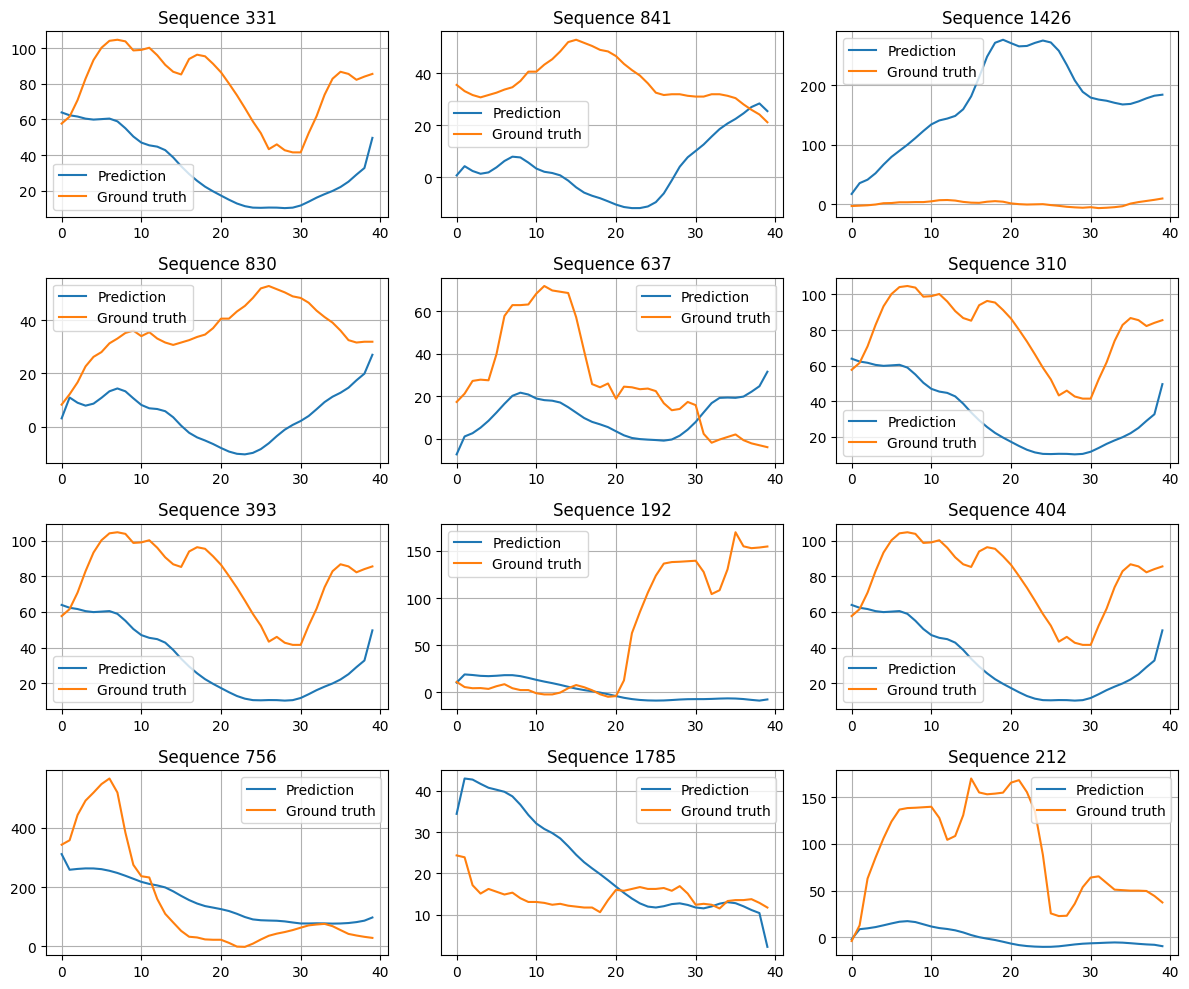

In [25]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(4, 3, figsize=(12, 10))
fig.tight_layout(pad=3.0)

# Iterate through a linear index to populate subplots
for i in range(12):
    n_rand = np.random.randint(low=0, high=pred.shape[0])
    row = i // 3  # Compute row index
    col = i % 3   # Compute column index
    ax = axes[row, col]
    
    # Example plot (sine waves with different frequencies)
    ax.plot(pred[n_rand,:, 0])
    ax.plot(true[n_rand,:, 0])
    ax.legend(["Prediction", "Ground truth"])
    ax.set_title(f"Sequence {n_rand}")
    ax.grid(True)
    
    # Hide the y-axis
    #ax.yaxis.set_visible(False)

# Adjust spacing between subplots
plt.tight_layout()
plt.show()



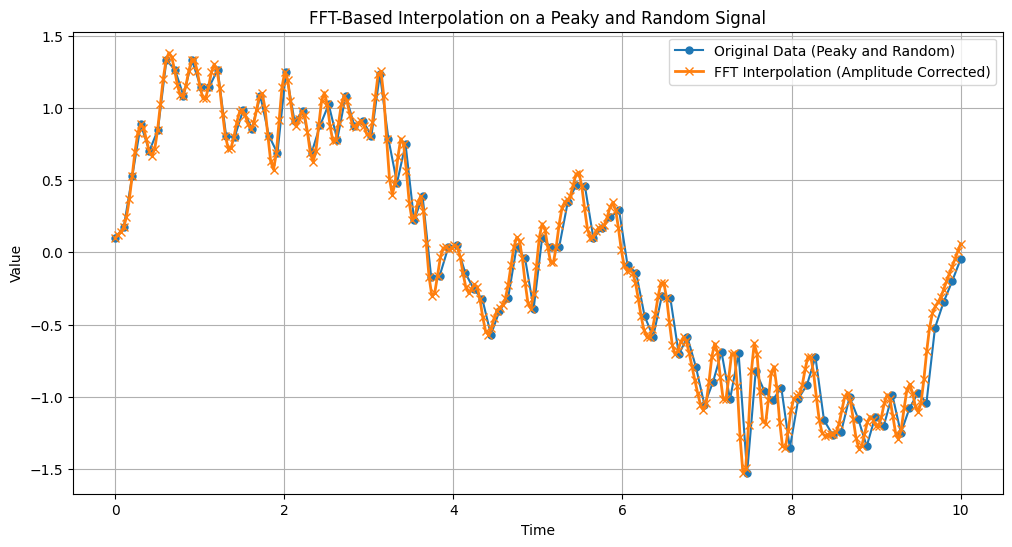

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Original time series
np.random.seed(42)  # For reproducibility
N = 100  # Original number of points
M = 300  # Desired number of points
x = np.linspace(0, 10, N)

# Generate a peaky and random signal: combination of sine waves + random noise
y = (np.sin(2 * np.pi * x / 10) + 
     0.5 * np.sin(4 * np.pi * x / 10) + 
     0.3 * np.sin(8 * np.pi * x / 10)) + 0.2 * np.random.randn(N)

# FFT of the original signal
fft_y = np.fft.fft(y)

# Zero-padding in the frequency domain
zero_pad = M - N
fft_y_padded = np.concatenate([
    fft_y[:N//2],  # First half of FFT
    np.zeros(zero_pad),  # Zeros in the middle
    fft_y[N//2:]  # Second half of FFT
])

# Inverse FFT to get interpolated signal
y_interpolated = np.fft.ifft(fft_y_padded).real  # Take the real part

# Scale the interpolated signal to match the original amplitude
scale_factor = M / N
y_interpolated *= scale_factor

# New time points
x_new = np.linspace(0, 10, M)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(x, y, 'o-', label='Original Data (Peaky and Random)', markersize=5)
plt.plot(x_new, y_interpolated, 'x-', label='FFT Interpolation (Amplitude Corrected)', linewidth=2)
plt.legend()
plt.title('FFT-Based Interpolation on a Peaky and Random Signal')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()


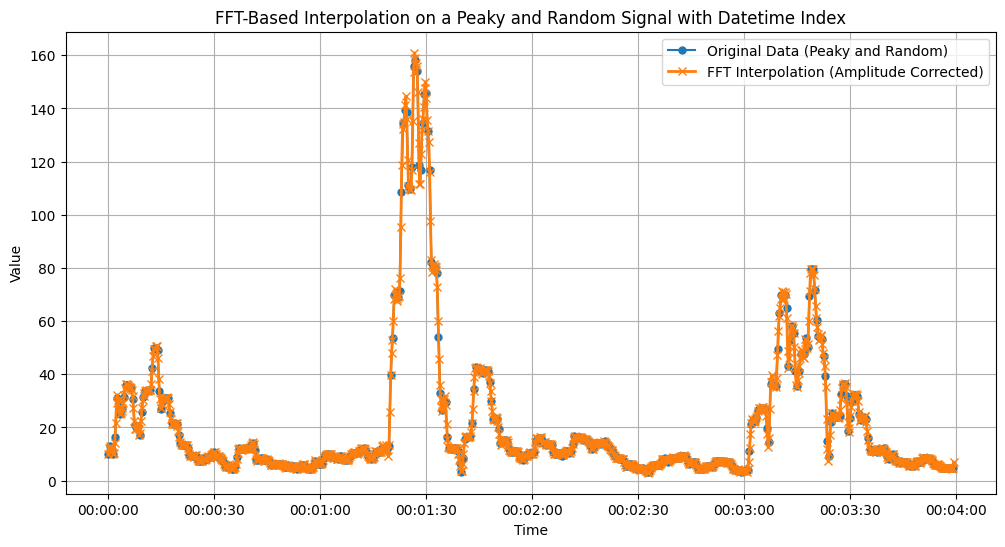

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

# Original time series in a pandas DataFrame
np.random.seed(42)  # For reproducibility
N = a.shape[0]  # Original number of points
M = 1000 # Desired number of points
start_time = pd.Timestamp("2024-11-17 00:00:00")
time_delta = timedelta(seconds=0.5)

# Generate datetime entries
x = [start_time + i * time_delta for i in range(N)]

# Generate a peaky and random signal
y = (np.sin(2 * np.pi * np.arange(N) / 10) +
     0.5 * np.sin(4 * np.pi * np.arange(N) / 10) +
     0.3 * np.sin(8 * np.pi * np.arange(N) / 10)) + 0.2 * np.random.randn(N)
y = a.squeeze()
# Create a pandas DataFrame
df = pd.DataFrame({'datetime': x, 'y': y})

# FFT of the signal
fft_y = np.fft.fft(df['y'].values)

# Zero-padding in the frequency domain
zero_pad = M - N
fft_y_padded = np.concatenate([
    fft_y[:N // 2],  # First half of FFT
    np.zeros(zero_pad),  # Zeros in the middle
    fft_y[N // 2:]  # Second half of FFT
])

# Inverse FFT to get interpolated signal
y_interpolated = np.fft.ifft(fft_y_padded).real  # Take the real part

# Scale the interpolated signal to match the original amplitude
scale_factor = M / N
y_interpolated *= scale_factor

# Generate new datetime entries
x_new = [start_time + i * time_delta / (M / N) for i in range(M)]

# Create a new pandas DataFrame for the interpolated signal
df_interpolated = pd.DataFrame({'datetime': x_new, 'y': y_interpolated})

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df['datetime'], df['y'], 'o-', label='Original Data (Peaky and Random)', markersize=5)
plt.plot(df_interpolated['datetime'], df_interpolated['y'], 'x-', label='FFT Interpolation (Amplitude Corrected)', linewidth=2)
plt.legend()
plt.title('FFT-Based Interpolation on a Peaky and Random Signal with Datetime Index')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()


In [47]:
df

,datetime,y
0,2024-11-17 00:00:00.000,0.099343
1,2024-11-17 00:00:00.500,1.211996
2,2024-11-17 00:00:01.000,1.089170
3,2024-11-17 00:00:01.500,1.247087
4,2024-11-17 00:00:02.000,-0.110909
...,...,...
130,2024-11-17 00:01:05.000,-0.310133
131,2024-11-17 00:01:05.500,1.253362
132,2024-11-17 00:01:06.000,0.747171
133,2024-11-17 00:01:06.500,1.037199


In [48]:
df_interpolated

,datetime,y
0,2024-11-17 00:00:00.000,0.099343
1,2024-11-17 00:00:00.225,0.830046
2,2024-11-17 00:00:00.450,1.195701
3,2024-11-17 00:00:00.675,1.152517
4,2024-11-17 00:00:00.900,1.062614
...,...,...
295,2024-11-17 00:01:06.375,1.031367
296,2024-11-17 00:01:06.600,0.920555
297,2024-11-17 00:01:06.825,0.302355
298,2024-11-17 00:01:07.050,-0.364366


In [56]:
a = np.load("../test1.npy",allow_pickle=True)
b = np.load("../test2.npy",allow_pickle=True)

In [63]:
c = np.load("../test3.npy",allow_pickle=True)
d = np.load("../test4.npy",allow_pickle=True)

In [61]:
a.shape, b.shape

((479, 1), (1000,))

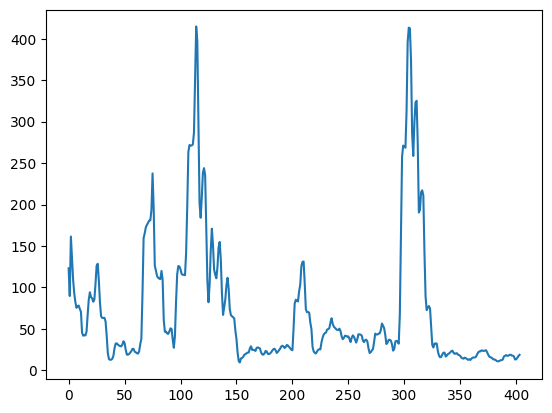

In [64]:
plt.plot(c)
plt.show()

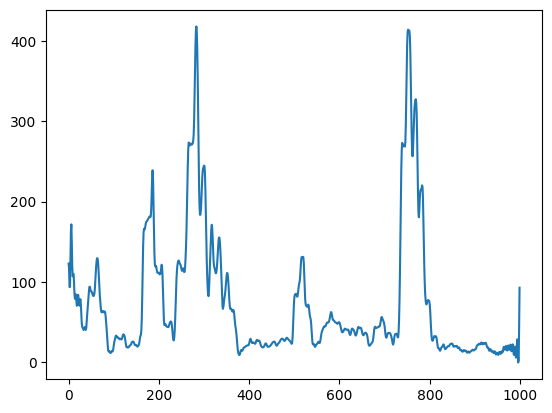

In [65]:
plt.plot(d)
plt.show()